In [138]:
import numpy as np
import netCDF4 as nc
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cartopy.crs as ccrs
import scipy
import seaborn as sn
import pandas as pd
import ipywidgets
from datetime import datetime, timedelta
import glob
from sklearn.linear_model import LinearRegression
import pymannkendall as mk

In [139]:
def moving_average(timeseries, step):
    return np.convolve(timeseries, np.ones(step), 'valid') / step -0.5

In [182]:
def pd_average(df,step):
    avg = df.resample('{}Y'.format(step),axis=0,group_keys=True,closed='left',label='right').mean() 
    return avg

In [141]:
def stats_of_timeseries(dates,timeseries_data):
    reg = LinearRegression().fit(dates, timeseries_data)
    mk_t = mk.original_test(timeseries_data)
    return reg, mk_t

In [142]:
import gc

In [143]:
gc.enable()

# Load data

In [144]:
ROOT = "/data/datasets/Projects/TuringCoccolithophoreBlooms"

In [145]:
filtered_filepath = ROOT+"/AVHRR_reflectance/MASKED_AVHRR/rrs_masked_by_sea_ice.nc"
varname = "filtered_remote_sensing_reflectance"

ds = xr.open_dataset(filtered_filepath)
print(ds)
rrs = ds[varname]

<xarray.Dataset>
Dimensions:                              (longitude: 3600, latitude: 1800,
                                          time: 424)
Coordinates:
  * longitude                            (longitude) float64 -179.9 ... 179.9
  * latitude                             (latitude) float64 -89.95 ... 89.95
  * time                                 (time) datetime64[ns] 1981-09-30 ......
Data variables:
    filtered_remote_sensing_reflectance  (time, latitude, longitude) float64 ...


# Calculate lat lon grid

In [146]:
#Get edges of grid cells (assuming consistent lat, lon grid)
lon = np.array(ds['longitude'])-0.05
lat = np.array(ds['latitude'])-0.025

#Get end of grid
lon = np.append(lon,ds['longitude'][-1])
lat = np.append(lat,ds['latitude'][-1])

#make into grid
x,y = np.meshgrid(lon,lat)

# Calculate area of grid cells

In [147]:
# Radius of Earth
R = 6371*1000

#Empty area for area
A = np.zeros((len(lon)-1,len(lat)-1))

#Cut grids
x_shift1 = x[1:,1:]
y_shift1 = y[1:,1:]

#Calculate area
A = np.pi/180 * R**2 * (np.sin(y[:-1,:-1]*np.pi/180)-np.sin(y_shift1*np.pi/180))*(x[:-1,:-1]-x_shift1)

In [148]:
#Standard deviation
std = np.nanstd(rrs)
rrs_time = pd.to_datetime(rrs.time.values)

In [230]:
#Calculate the area for each month covered by those areas classed as bloom (> 1 standard deviation)

m_areas = np.zeros(len(rrs_time))
for i in range(0,len(rrs_time)):
    #Find area with rrs higher than standard deviation
    m_areas[i] = np.nansum(A[rrs[i,:,:]>std])

In [151]:
#array for number of months considered in timeseries
months = np.arange(0,len(rrs_time))

In [152]:
pd_area = pd.DataFrame(m_areas,index=rrs_time)

Mann_Kendall_Test(trend='decreasing', h=True, p=8.259515825814745e-05, z=-3.936742480521045, Tau=-0.12799411213702663, s=-11478.0, var_s=8499292.0, slope=-734.720798535706, intercept=519828.4884691961)
Slope =  -2400.976359732011
Change in area =  [2177788.20998631]


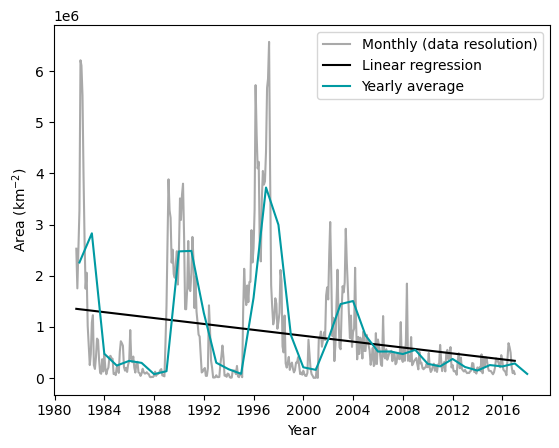

In [241]:
plt.plot(rrs_time,m_areas/(1000*1000),color='darkgray',label='Monthly (data resolution)')
reg, mk_t = stats_of_timeseries(months.reshape(-1, 1),m_areas/(1000*1000))
print(mk_t)
plt.plot(rrs_time,reg.intercept_+reg.coef_[0]*months,'k',label='Linear regression')
print('Slope = ',reg.coef_[0])

#Averaging steps (years)
steps=[1]

for i,step in enumerate(steps):
    avg = pd_average(pd_area,step)

    if step==1:
        plt.plot(avg.index,avg.values/(1000*1000),color=(0, 154/255, 162/255),label='Yearly average')
        print('Change in area = ',(avg.values[0]-avg.values[-1])/(1000*1000))

    else:
        plt.plot(avg.index,avg.values/(1000*1000),'--',label='Steps = {}'.format(step))
        plt.legend()
        
plt.legend(loc='upper right')
plt.xlabel('Year')
plt.ylabel('Area (km$^{-2}$)')
plt.savefig('month_area_timeseries.png')

# Decadal boxplots

In [232]:
#slices
slice_1 = slice('1981-01-01','1989-12-01')
slice_2 = slice('1990-01-01','1999-12-01')
slice_3 = slice('2000-01-01','2009-12-01')
slice_4 = slice('2010-01-01','2016-12-01')
slices=[slice_1,slice_2,slice_3,slice_4]

In [45]:
decade_1 = rrs.sel(time=slice_1)
decade_2 = rrs.sel(time=slice_2)
decade_3 = rrs.sel(time=slice_3)
decade_4 = rrs.sel(time=slice_4)

In [ ]:
d1_mean = np.array(decade_1.mean(dim=['latitude','longitude'],skipna=True)).flatten()
d2_mean = np.array(decade_2.mean(dim=['latitude','longitude'],skipna=True)).flatten()
d3_mean = np.array(decade_3.mean(dim=['latitude','longitude'],skipna=True)).flatten()
d4_mean = np.array(decade_4.mean(dim=['latitude','longitude'],skipna=True)).flatten()

In [55]:
d_means = [d1_mean[~np.isnan(d1_mean)],d2_mean[~np.isnan(d2_mean)],d3_mean[~np.isnan(d3_mean)],d4_mean[~np.isnan(d4_mean)]]

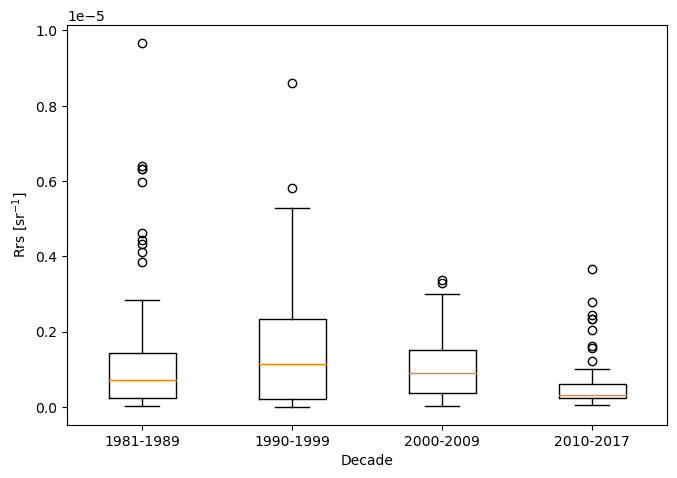

In [66]:
# Define the figure and each axis
fig = plt.figure(figsize =(6, 4))
 
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
 
# Creating plot
bp = ax.boxplot(d_means)

#Format plot
ax.set_xlabel('Decade')
ax.set_ylabel('Rrs [sr$^{-1}$]')
ax.set_xticks([1,2,3,4],['1981-1989','1990-1999','2000-2009','2010-2017'])

plt.savefig('Decadal_boxplots.png',bbox_inches='tight', dpi=350) 

# Decadal map of number of pixels defined as bloom

In [234]:
import cartopy.crs as ccrs
import cartopy.feature as cfeat
from matplotlib import colors
from matplotlib.colors import LinearSegmentedColormap

In [235]:
colors = [(0, 24/255, 95/255),(0, 154/255, 162/255),(126/255, 201/255, 201/255),(173/255, 255/255, 251/255)]#,(1, 1, 1)]
cmap = LinearSegmentedColormap.from_list('coccolithphores', colors, N=100)

In [236]:
from matplotlib import colors

In [237]:
d1_mean = decade_1.mean(dim='time',skipna=True)
d2_mean = decade_2.mean(dim='time',skipna=True)
d3_mean = decade_3.mean(dim='time',skipna=True)
d4_mean = decade_4.mean(dim='time',skipna=True)
all_mean = rrs.mean(dim='time',skipna=True)

In [238]:
d_means = [d1_mean,d2_mean,d3_mean,d4_mean]

In [239]:
gc.collect()

17856

In [ ]:
# Define the figure and each axis
fig, axs = plt.subplots(nrows=2,ncols=2,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(11,8.5))
axs=axs.flatten()

for i,d_mean in enumerate(d_means):

    im=axs[i].pcolor(d_mean.longitude,d_mean.latitude,d_mean.values,
                          transform = ccrs.PlateCarree(),
                          cmap=cmap,norm=colors.LogNorm(vmin=1e-6, vmax=1e-2))
    axs[i].coastlines()
    cmap.set_bad((0, 24/255, 95/255))
    gl = axs[i].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=0.33, color='k',alpha=0)
    gl.xlabels_bottom = False
    gl.ylabels_right = False
    axs[i].add_feature(cfeat.LAND,color='lightgray')
    axs[i].add_feature(cfeat.COASTLINE)

    
cbar = plt.colorbar(im,ax=axs.ravel().tolist(),location="bottom")
cbar.set_label('Rrs [sr$^{-1}$]')

plt.savefig('Decadal_trends.png')